Importing Libraries:

In [97]:
import pandas as pd
import numpy as np  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

Common Functions to use:

In [98]:
def sigmoid(z):
    z = np.clip(z, -500, 500) #to avoid overflow
    return 1 / (1 + np.exp(-z))

def crossEntropyLoss(y_true, y_pred):
    return -(1/len(y_true)) * np.sum(y_true * np.log(y_pred+1e-15) + (1 - y_true) * np.log(1 - y_pred+1e-15))

def accuracy(y_true, y_pred):
    return np.mean((y_pred >= 0.5) == y_true)

Preprocessing Dataset:

In [99]:
dataset = pd.read_csv('HeartDisease.csv')


#filling categorical missing values with mode
columns_to_fill = ['education', 'cigsPerDay', 'BPMeds']
modes = dataset[columns_to_fill].mode().iloc[0]
dataset[columns_to_fill] = dataset[columns_to_fill].fillna(modes)

#filling numerical missing values with mean
columns_to_fill = ['totChol', 'BMI', 'glucose', "heartRate"]
means = dataset[columns_to_fill].mean()
dataset[columns_to_fill] = dataset[columns_to_fill].fillna(means)


#undersample majority class for balanced dataset
majority_class = dataset['HeartDisease'].value_counts().idxmax()
minority_class = dataset['HeartDisease'].value_counts().idxmin()
majority_class_data = dataset[dataset['HeartDisease'] == majority_class]
minority_class_data = dataset[dataset['HeartDisease'] == minority_class]
majority_class_undersampled = majority_class_data.sample(len(minority_class_data), random_state=42)
undersampled_dataset = pd.concat([majority_class_undersampled, minority_class_data])
undersampled_dataset = undersampled_dataset.sample(frac=1, random_state=42).reset_index(drop=True)
dataset = undersampled_dataset



#split dataset into train, validation and test sets
trainSet, tempSet = train_test_split(dataset, test_size=0.30, random_state=1)
valSet, testSet = train_test_split(tempSet, test_size=0.50, random_state=1)

(a)

In [100]:
def LogisticRegressionBatchGD(X_train, y_train, X_val, y_val, learning_rate, epochs):
    m = len(y_train)
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    weights = np.zeros(X_train.shape[1])
    bias = 0
    for i in range(epochs):
        z = np.dot(X_train, weights) + bias
        y_pred = sigmoid(z)
        #update weights and bias:
        dw = (1/m) * np.dot(X_train.T, y_pred - y_train)
        db = (1/m) * np.sum(y_pred - y_train)
        weights -= learning_rate * dw
        bias -= learning_rate * db

        #do the predictions
        y_train_pred = sigmoid(np.dot(X_train, weights) + bias)
        y_val_pred = sigmoid(np.dot(X_val, weights) + bias)

        train_loss = crossEntropyLoss(y_train, y_train_pred)
        val_loss = crossEntropyLoss(y_val, y_val_pred)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)

        train_accuracy = accuracy(y_train, y_train_pred)
        val_accuracy = accuracy(y_val, y_val_pred)
        train_accuracy_history.append(train_accuracy)
        val_accuracy_history.append(val_accuracy)

    return weights, bias, train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history, y_val_pred


X_train = trainSet.drop(columns=['HeartDisease'])
y_train = trainSet['HeartDisease']
X_val = valSet.drop(columns=['HeartDisease'])
y_val = valSet['HeartDisease']

weights, bias, train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history, y_val_pred = LogisticRegressionBatchGD(X_train, y_train,X_val, y_val, learning_rate=0.1, epochs=10000)



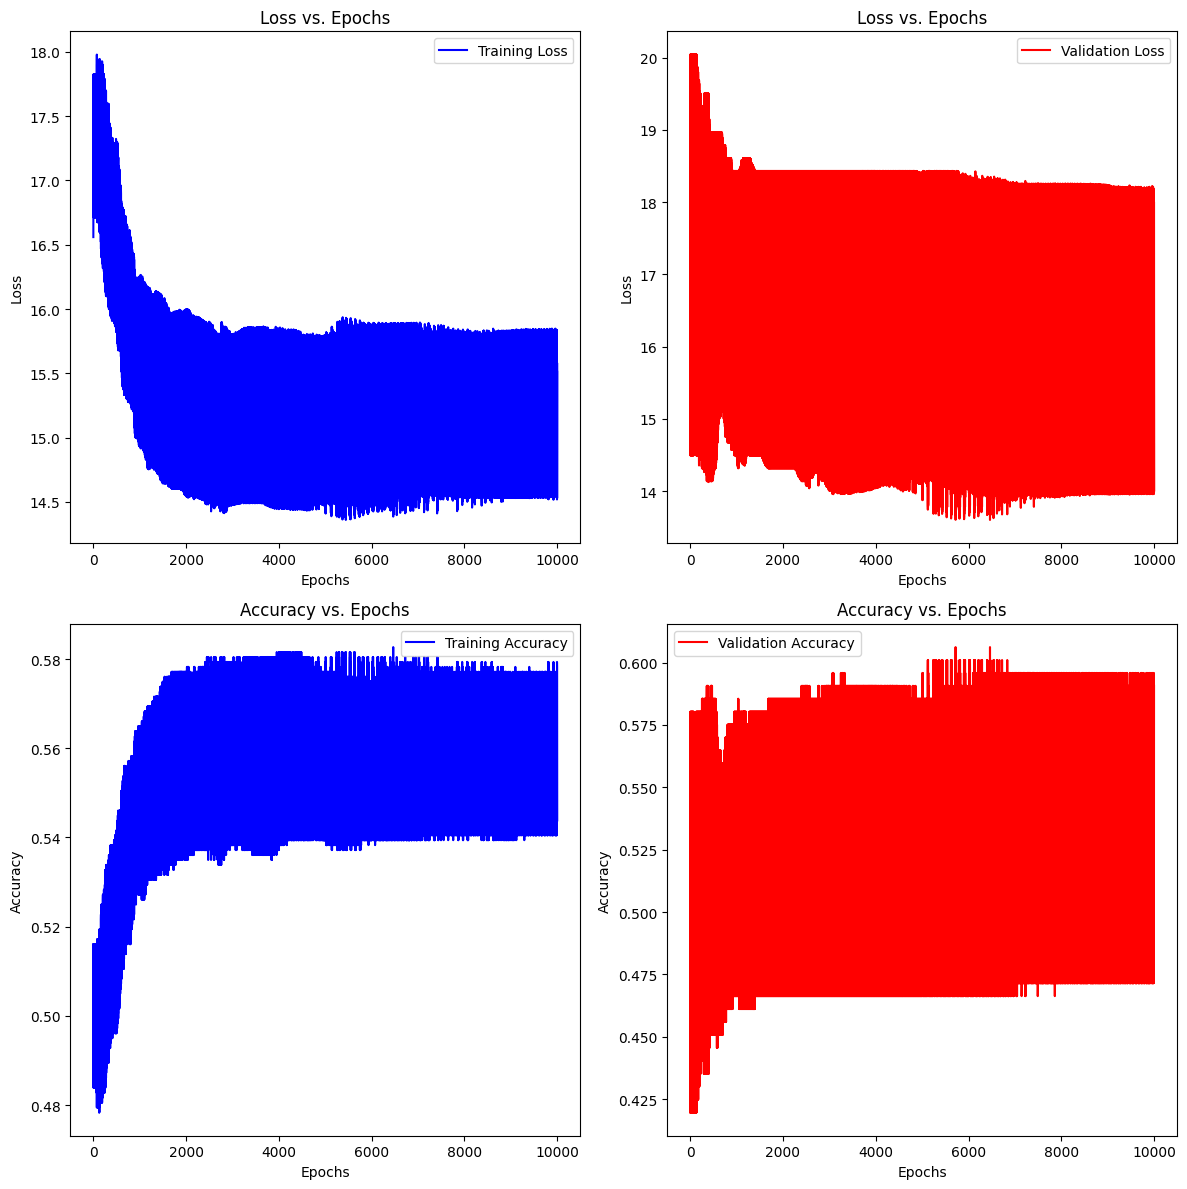

In [101]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 2,1)
plt.plot(train_loss_history, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

plt.subplot(2, 2,2)
plt.plot(val_loss_history, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_accuracy_history, label='Training Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(val_accuracy_history, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()

plt.tight_layout()
plt.show()

(b)

In [102]:
def min_max_scaler(givenData):
    scaled_data = givenData.copy()
    for column in ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']:
        min_value = givenData[column].min()
        max_value = givenData[column].max()
        scaled_data[column] = (givenData[column] - min_value) / (max_value - min_value)
    return scaled_data

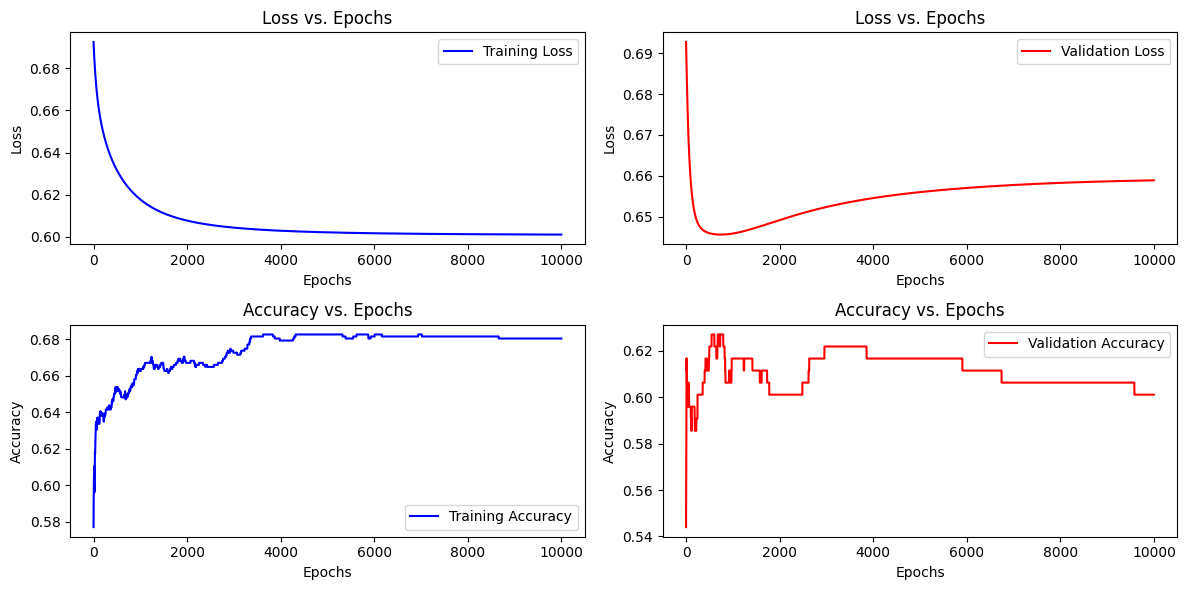

In [103]:
X_train_scaled = min_max_scaler(X_train)
X_val_scaled = min_max_scaler(X_val)
weights, bias, train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history,y_val_pred = LogisticRegressionBatchGD(X_train_scaled, y_train, X_val_scaled, y_val, 0.1, 10000)

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(train_loss_history, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(val_loss_history, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_accuracy_history, label='Training Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(val_accuracy_history, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()

plt.tight_layout()
plt.show()

(c) Used minmax scaler because to compute confusion matrix because it produced better results.

In [104]:
val_y_pred_binary = (y_val_pred >= 0.5).astype(int)
conf_matrix = confusion_matrix(y_val, val_y_pred_binary)
tn, fp, fn, tp = conf_matrix.ravel()

precision = precision_score(y_val, val_y_pred_binary)
recall = recall_score(y_val, val_y_pred_binary)
f1 = f1_score(y_val, val_y_pred_binary)
roc_auc = roc_auc_score(y_val, val_y_pred_binary)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")


Confusion Matrix:
[[57 24]
 [53 59]]
Precision: 0.7108
Recall: 0.5268
F1 Score: 0.6051
ROC-AUC Score: 0.6152


(d)

In [105]:
def LogisticRegressionSGD(X_train, y_train, X_val, y_val, X_test, y_test, learning_rate, epochs):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    m = len(y_train)
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    test_loss_history = []
    test_accuracy_history = []
    weights = np.zeros(X_train.shape[1])
    bias = 0
    
    for epoch in range(epochs):
        permutation = np.random.permutation(m)
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]
        
        for j in range(m):
            X_i = X_train_shuffled[j].reshape(1, -1)
            y_i = y_train_shuffled[j]
            z = np.dot(X_i, weights) + bias
            y_pred = sigmoid(z)
            dw = np.dot(X_i.T, y_pred - y_i)
            db = y_pred - y_i
            weights -= learning_rate * dw.flatten()
            bias -= learning_rate * db
        
        y_train_pred = sigmoid(np.dot(X_train, weights) + bias)
        y_val_pred = sigmoid(np.dot(X_val, weights) + bias)
        y_test_pred = sigmoid(np.dot(X_test, weights) + bias)
        
        train_loss = crossEntropyLoss(y_train, y_train_pred)
        val_loss = crossEntropyLoss(y_val, y_val_pred)
        test_loss = crossEntropyLoss(y_test, y_test_pred)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        test_loss_history.append(test_loss)
        
        train_accuracy = accuracy(y_train, y_train_pred)
        val_accuracy = accuracy(y_val, y_val_pred)
        test_accuracy = accuracy(y_test, y_test_pred)
        train_accuracy_history.append(train_accuracy)
        val_accuracy_history.append(val_accuracy)
        test_accuracy_history.append(test_accuracy)
        
    
    return weights, bias, train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history, test_loss_history, test_accuracy_history, y_test_pred


X_test = testSet.drop(columns=['HeartDisease'])
y_test = testSet['HeartDisease']
X_test_scaled=min_max_scaler(X_test)
weights_sgd, bias_sgd, train_loss_sgd, train_acc_sgd, val_loss_sgd, val_acc_sgd, test_loss_sgd, test_acc_sgd, y_test_pred_sgd = LogisticRegressionSGD(X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, 0.001, 500)

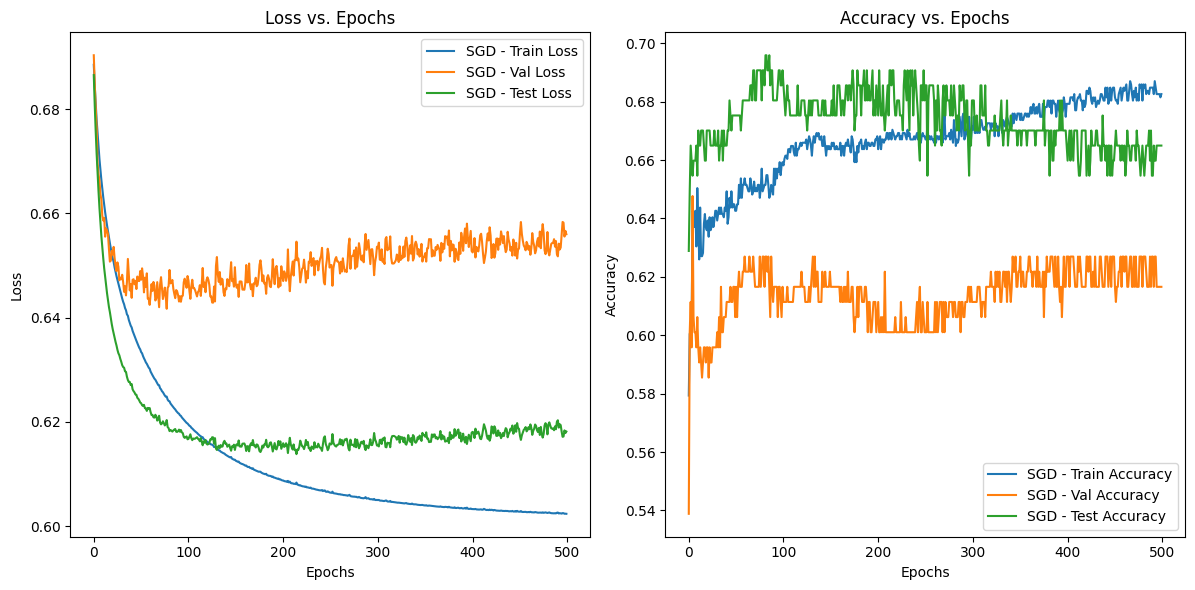

In [106]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(train_loss_sgd, label='SGD - Train Loss')
plt.plot(val_loss_sgd, label='SGD - Val Loss')
plt.plot(test_loss_sgd, label='SGD - Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(train_acc_sgd, label='SGD - Train Accuracy')
plt.plot(val_acc_sgd, label='SGD - Val Accuracy')
plt.plot(test_acc_sgd, label='SGD - Test Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

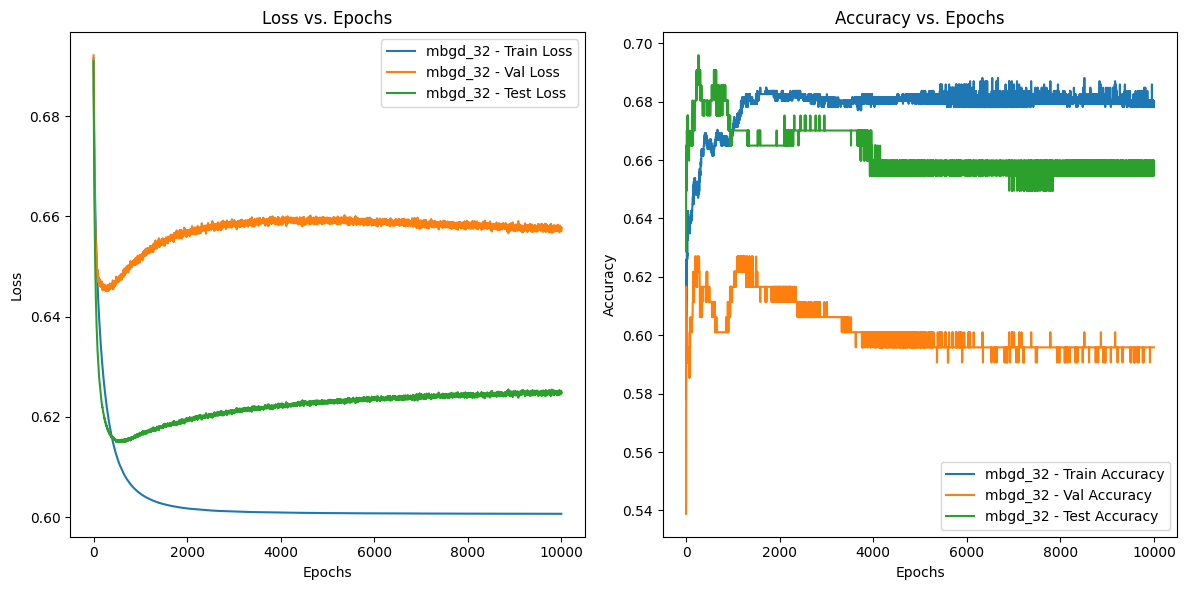

In [107]:
def LogisticRegressionMiniBatchGD(X_train, y_train, X_val, y_val, X_test, y_test, learning_rate, iterations, batch_size):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    m = len(y_train)
    train_cost_history = []
    val_cost_history = []
    test_cost_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    test_accuracy_history = []
    weights = np.zeros(X_train.shape[1])
    bias = 0
    
    for i in range(iterations):
        permutation = np.random.permutation(m)
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]

        for j in range(0, m, batch_size):
            X_batch = X_train_shuffled[j:j+batch_size]
            y_batch = y_train_shuffled[j:j+batch_size]

            z = np.dot(X_batch, weights) + bias
            y_pred = sigmoid(z)

            dw = np.dot(X_batch.T, y_pred - y_batch) / batch_size
            db = np.sum(y_pred - y_batch) / batch_size

            weights -= learning_rate * dw
            bias -= learning_rate * db

        y_train_pred = sigmoid(np.dot(X_train, weights) + bias)
        y_val_pred = sigmoid(np.dot(X_val, weights) + bias)
        y_test_pred = sigmoid(np.dot(X_test, weights) + bias)

        train_loss = crossEntropyLoss(y_train, y_train_pred)
        val_loss = crossEntropyLoss(y_val, y_val_pred)
        test_loss = crossEntropyLoss(y_test, y_test_pred)
        
        train_cost_history.append(train_loss)
        val_cost_history.append(val_loss)
        test_cost_history.append(test_loss)

        train_accuracy = accuracy(y_train, y_train_pred)
        val_accuracy = accuracy(y_val, y_val_pred)
        test_accuracy = accuracy(y_test, y_test_pred)
        
        train_accuracy_history.append(train_accuracy)
        val_accuracy_history.append(val_accuracy)
        test_accuracy_history.append(test_accuracy)

    return (weights, bias, train_cost_history, val_cost_history, test_cost_history, train_accuracy_history, val_accuracy_history, test_accuracy_history)


batch_size = 32
weights_mbgd_32, bias_mbgd_32, train_cost_mbgd_32, val_cost_mbgd_32, test_cost_mbdg_32, train_acc_mbgd_32, val_acc_mbgd_32 ,test_acc_mbdg_32= LogisticRegressionMiniBatchGD(X_train_scaled, y_train, X_val_scaled, y_val,X_test_scaled,y_test, 0.01, 10000, batch_size)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_cost_mbgd_32, label='mbgd_32 - Train Loss')
plt.plot(val_cost_mbgd_32, label='mbgd_32 - Val Loss')
plt.plot(test_cost_mbdg_32, label='mbgd_32 - Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_mbgd_32, label='mbgd_32 - Train Accuracy')
plt.plot(val_acc_mbgd_32, label='mbgd_32 - Val Accuracy')
plt.plot(test_acc_mbdg_32, label='mbgd_32 - Test Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

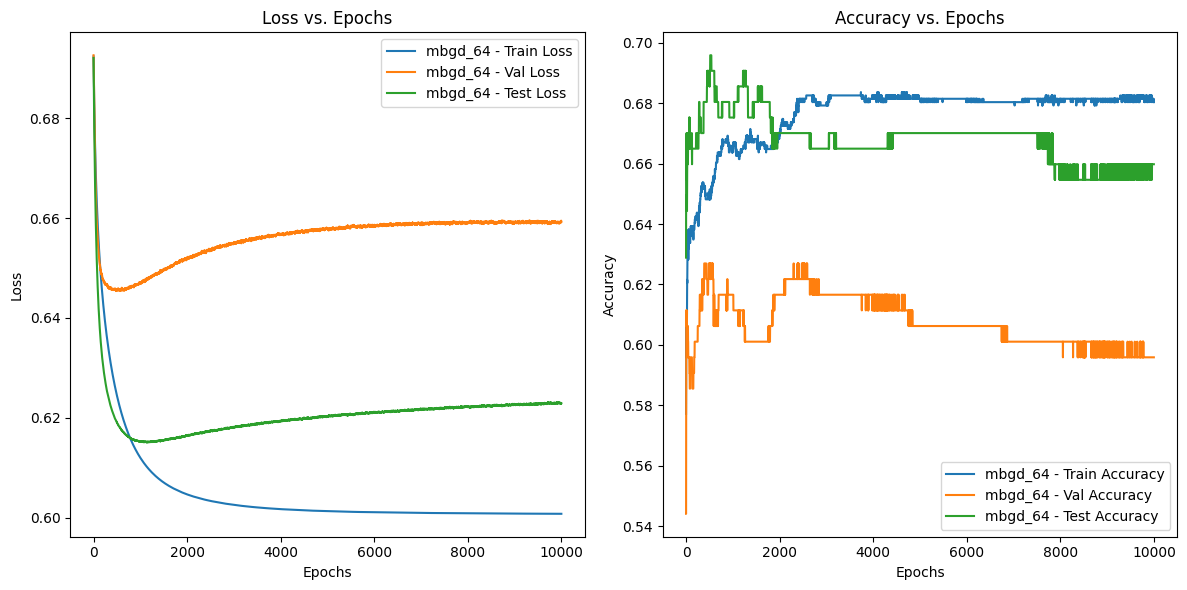

In [108]:
batch_size = 64
weights_mbgd_64, bias_mbgd_64, train_cost_mbgd_64, val_cost_mbgd_64, test_cost_mbdg_64, train_acc_mbgd_64, val_acc_mbgd_64, test_acc_mbdg_64 = LogisticRegressionMiniBatchGD(X_train_scaled, y_train, X_val_scaled, y_val,X_test_scaled,y_test, 0.01, 10000, batch_size)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_cost_mbgd_64, label='mbgd_64 - Train Loss')
plt.plot(val_cost_mbgd_64, label='mbgd_64 - Val Loss')
plt.plot(test_cost_mbdg_64, label='mbgd_64 - Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_mbgd_64, label='mbgd_64 - Train Accuracy')
plt.plot(val_acc_mbgd_64, label='mbgd_64 - Val Accuracy')
plt.plot(test_acc_mbdg_64, label='mbgd_64 - Test Accuracy')

plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [109]:
def k_fold_cross_validation(X, y, k, learning_rate, epochs):
    fold_size = len(y) // k
    folds_X = [X[i*fold_size:(i+1)*fold_size] for i in range(k)]
    folds_y = [y[i*fold_size:(i+1)*fold_size] for i in range(k)]
    
    accuracies, precisions, recalls, f1_scores = [], [], [], []

    for i in range(k):
        X_val, y_val = folds_X[i], folds_y[i]
        X_train = np.vstack([folds_X[j] for j in range(k) if j != i])
        y_train = np.hstack([folds_y[j] for j in range(k) if j != i])
        
        weights, bias,a,b,c,d,e = LogisticRegressionBatchGD(X_train, y_train, X_val, y_val, learning_rate, epochs)
        
        y_val_pred_prob = sigmoid(np.dot(X_val, weights) + bias)
        y_val_pred = (y_val_pred_prob >= 0.5).astype(int)
        
        accuracies.append(np.mean((y_val==y_val_pred)))
        precisions.append(precision_score(y_val, y_val_pred))
        recalls.append(recall_score(y_val, y_val_pred))
        f1_scores.append(f1_score(y_val, y_val_pred))

    print(f'Accuracy: Mean = {np.mean(accuracies):.4f}, Std = {np.std(accuracies):.4f}')
    print(f'Precision: Mean = {np.mean(precisions):.4f}, Std = {np.std(precisions):.4f}')
    print(f'Recall: Mean = {np.mean(recalls):.4f}, Std = {np.std(recalls):.4f}')
    print(f'F1 Score: Mean = {np.mean(f1_scores):.4f}, Std = {np.std(f1_scores):.4f}')

X = dataset.drop(columns=['HeartDisease'])
y = dataset['HeartDisease']
k_fold_cross_validation(X, y,5, 0.1, 1000)


Accuracy: Mean = 0.5447, Std = 0.0210
Precision: Mean = 0.8277, Std = 0.0708
Recall: Mean = 0.1106, Std = 0.0177
F1 Score: Mean = 0.1945, Std = 0.0280
